# Guess your age

*by: Rakesh P. Tiwari (a fastai project to learn cnns)*

In [2]:
from fastai import *
from fastai.vision import *

## Get Adience data from 
https://talhassner.github.io/home/projects/Adience/Adience-data.html

After unzipping the data images we find that images are contained in 168 folders. The folder names are user ids.
I first moved all .jpg into a single folder using the following python code. Choose src_dir and dst_dir as appropriate:

import os

import shutil

src_dir = r'/Users/tiwari/Downloads/faces/images'

dst_dir = r'/Users/tiwari/Downloads/faces/Allimages'

for root, dirs, files in os.walk(src_dir):

    for f in files:
    
        if f.endswith('.jpg'):
        
            shutil.copy(os.path.join(root,f), dst_dir)



### Download the labels

I extracted labels from fold_0_data.txt, fold_1_data.txt, fold_2_data.txt, fold_3_data.txt, fold_4_data.txt

First I joined all of these files into a single file getlabelsfrom.txt.

I would like to use ImageDataBunch from df.

I notice that to get labels the names of jpg files have to match the names of the image files. Since this is not the case by default here I did that using the following code

import os

#import glob

import re

for root,dirs,files in os.walk(r'/Users/tiwari/Downloads/faces/Allimages'):

    for f in files:

        pattern = r'coarse_tilt_aligned_face.\d+.'
        
        replace = r''
        
        newname = re.sub(pattern, replace, f)
        
        os.rename(os.path.join(root, f), os.path.join(root, newname))



### Creating labels

Now I would like to replace data with no labels

In [4]:
path=Path('data/agedata')
path.ls()

[PosixPath('data/agedata/models'),
 PosixPath('data/agedata/export.pkl'),
 PosixPath('data/agedata/getlabelsfrom.txt'),
 PosixPath('data/agedata/Allimages.zip'),
 PosixPath('data/agedata/nicoletest.tiff'),
 PosixPath('data/agedata/Allimages'),
 PosixPath('data/agedata/rakeshtest2.tiff'),
 PosixPath('data/agedata/avnitest1.jpeg'),
 PosixPath('data/agedata/rakeshtest1.jpg.tiff'),
 PosixPath('data/agedata/avnitest2.jpeg'),
 PosixPath('data/agedata/avnitest3.jpeg'),
 PosixPath('data/agedata/nicoletest2.tiff')]

In [10]:
path=Path('data/agedata')
import zipfile
zip_ref = zipfile.ZipFile('data/agedata/Allimages.zip', 'r')
zip_ref.extractall(path)
zip_ref.close()

Now lets load the labels file into a dataframe

In [5]:
import pandas as pd
import re

df = pd.read_csv('data/agedata/getlabelsfrom.txt', sep='\\t', engine='python')

df.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score\
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17\
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94\
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74\
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47\
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34\


We note that some age columns are marked none and some have only a age example 55, which should be deleted as they
are not in the form of labels we want, which are (0,2), (4,6), (8,13), (15,20), (25,32), (38,43), (48,53), (60,).
There are also entries (8, 23) which we will like to remove, as I think it is a useless guess.
Lets do that step by step and check by looking at the shape of the dataframe.
If one wants to keep more labels we can use different dataframe from df, new_df, new_new_df, the_df to create imagedatabunch

In [6]:
print(df.shape[0])
n_df = df.drop(df[df['age']=='None'].index)
print(n_df.shape[0])
nn_df= n_df[n_df['age'].str.len().gt(2)]
print(nn_df.shape[0])
nnn_df= nn_df.drop(nn_df[nn_df['age']=='(38, 48)'].index)
print(nnn_df.shape[0])
nnnn_df= nnn_df.drop(nnn_df[nnn_df['age']=='(38, 42)'].index)
print(nnnn_df.shape[0])
nnnnn_df= nnnn_df.drop(nnnn_df[nnnn_df['age']=='(27, 32)'].index)
print(nnnnn_df.shape[0])
the_df= nnnnn_df.drop(nnnnn_df[nnnnn_df['age']=='(8, 23)'].index)
print(the_df.shape[0])
print(the_df.columns.get_loc("original_image"))
print(the_df.columns.get_loc("age"))

19370
18622
17523
17517
17471
17394
17393
1
3


## View data

In [7]:
get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, res

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_df(path, the_df, 'Allimages', None, 0.2,
                              
        1, 3, '', ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data.classes

['(0, 2)',
 '(15, 20)',
 '(25, 32)',
 '(38, 43)',
 '(4, 6)',
 '(48, 53)',
 '(60, 100)',
 '(8, 12)']

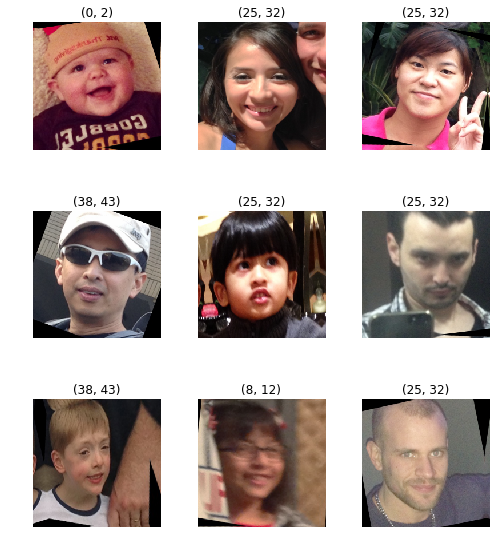

In [8]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['(0, 2)',
  '(15, 20)',
  '(25, 32)',
  '(38, 43)',
  '(4, 6)',
  '(48, 53)',
  '(60, 100)',
  '(8, 12)'],
 8,
 13915,
 3478)

## Train model

In [21]:
#save=SaveModelCallback()

NameError: name 'SaveModelCallback' is not defined

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [13]:
learn.fit_one_cycle(3,1e-4, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

NameError: name 'SaveModelCallback' is not defined

In [14]:
%debug

> <ipython-input-13-80c4fac872b9>(1)<module>()
----> 1 learn.fit_one_cycle(3,1e-4, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

ipdb> 
ipdb> n


In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


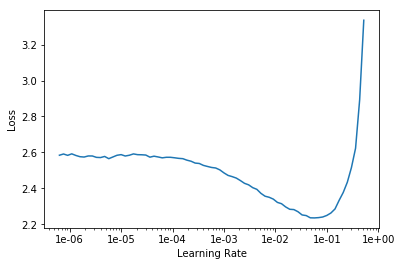

In [12]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 5e-03)

epoch,train_loss,valid_loss,error_rate,time


In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


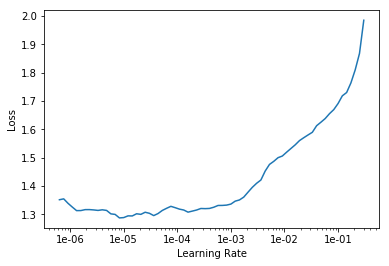

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2, slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,1.252300,1.255273,0.459747,01:34
1,0.994461,0.965989,0.330650,01:34


In [19]:
learn.fit_one_cycle(4, slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,1.030215,1.082360,0.376941,01:34
1,1.000918,1.008382,0.351926,01:35
2,0.818543,0.892729,0.310236,01:35
3,0.636254,0.860188,0.294997,01:35


In [20]:
learn.save('best-1-resnet34')

In [21]:
learn.fit_one_cycle(1, slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.796738,0.884735,0.300460,01:35


In [22]:
learn.fit_one_cycle(1, slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.739011,0.878364,0.307936,01:36


In [23]:
learn.fit_one_cycle(2, slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.800874,0.995858,0.368603,01:38
1,0.623951,0.839322,0.292697,01:36


In [24]:
learn.save('best-2-resnet34')

In [25]:
learn.fit_one_cycle(2, slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.730880,0.942386,0.319436,01:37
1,0.568739,0.857949,0.292697,01:37


In [26]:
learn.fit_one_cycle(2, slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.699938,0.997117,0.332375,01:36
1,0.535779,0.857199,0.286659,01:37


In [ ]:
learn.recorder.plot_losses()

## Interpretation

In [27]:
learn.load('best-1-resnet34');

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

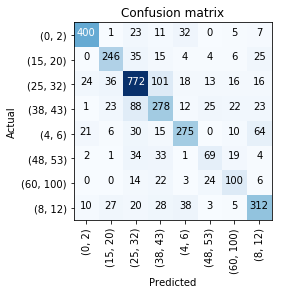

In [30]:
interp.plot_confusion_matrix()

In [17]:
interp.most_confused()

[('(38, 43)', '(25, 32)', 158),
 ('(25, 32)', '(38, 43)', 77),
 ('(8, 12)', '(25, 32)', 64),
 ('(15, 20)', '(25, 32)', 59),
 ('(4, 6)', '(8, 12)', 58),
 ('(48, 53)', '(25, 32)', 50),
 ('(8, 12)', '(4, 6)', 46),
 ('(60, 100)', '(25, 32)', 42),
 ('(0, 2)', '(4, 6)', 41),
 ('(4, 6)', '(25, 32)', 40),
 ('(48, 53)', '(38, 43)', 39),
 ('(0, 2)', '(25, 32)', 33),
 ('(8, 12)', '(15, 20)', 33),
 ('(8, 12)', '(38, 43)', 32),
 ('(4, 6)', '(0, 2)', 31),
 ('(25, 32)', '(15, 20)', 30),
 ('(25, 32)', '(4, 6)', 27),
 ('(38, 43)', '(60, 100)', 24),
 ('(60, 100)', '(38, 43)', 24),
 ('(60, 100)', '(48, 53)', 23),
 ('(15, 20)', '(8, 12)', 22),
 ('(38, 43)', '(8, 12)', 22),
 ('(48, 53)', '(60, 100)', 22),
 ('(25, 32)', '(8, 12)', 21),
 ('(38, 43)', '(15, 20)', 20),
 ('(38, 43)', '(48, 53)', 20),
 ('(25, 32)', '(0, 2)', 19),
 ('(25, 32)', '(60, 100)', 17),
 ('(15, 20)', '(38, 43)', 16),
 ('(4, 6)', '(15, 20)', 13),
 ('(4, 6)', '(38, 43)', 13),
 ('(25, 32)', '(48, 53)', 12),
 ('(4, 6)', '(60, 100)', 9),
 ('(

# Use resnet-50

In [9]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


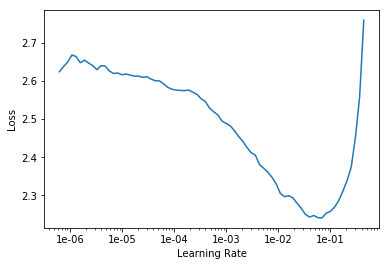

In [33]:
learn.recorder.plot()

In [11]:
lr=2e-03

In [11]:
learn.fit_one_cycle(2,lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.459755,1.276512,0.457159,02:22
1,1.206120,1.143593,0.407993,02:19


In [12]:
learn.unfreeze()

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


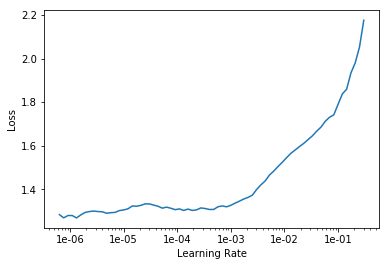

In [38]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/2), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,1.591321,1.337541,0.477861,02:23
1,1.342929,1.238071,0.435308,02:19


In [13]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/2),moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,1.292676,1.203070,0.435020,02:19
1,1.162259,1.134447,0.406556,02:19


In [14]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,1.119440,1.112756,0.402530,02:19
1,1.045800,1.080552,0.384416,02:19


In [15]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,1.047692,1.071315,0.382116,02:19
1,1.016867,1.054244,0.381829,02:19


In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5),moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,1.217780,1.139937,0.414894,03:05
1,0.947173,0.920376,0.325762,03:03


In [18]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,1.071624,1.154906,0.405405,03:00
1,0.812616,0.885268,0.320299,03:02


In [19]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,0.959335,1.068642,0.364865,03:02
1,0.722701,0.866501,0.303048,03:02


In [20]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,0.899216,0.993865,0.354227,03:02
1,0.676149,0.862534,0.303623,03:02


In [21]:
learn.save('resnet50model-1-March22')

In [22]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.95)

epoch,train_loss,valid_loss,error_rate,time
0,0.815701,1.024346,0.349914,03:02
1,0.616848,0.872621,0.303910,03:02


In [23]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,0.760947,0.946692,0.333237,03:01
1,0.584467,0.863917,0.295860,03:02


In [24]:
learn.save('resnet50model-2-March22')

In [25]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,0.720934,0.947027,0.332375,03:02
1,0.540367,0.879660,0.294422,03:02


In [26]:
learn.save('resnet50model-3-March22')

In [27]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,lr/5), moms=0.9)

epoch,train_loss,valid_loss,error_rate,time
0,0.685172,1.022141,0.337838,03:02
1,0.505353,0.886627,0.305348,03:02


In [16]:
interp = ClassificationInterpretation.from_learner(learn)

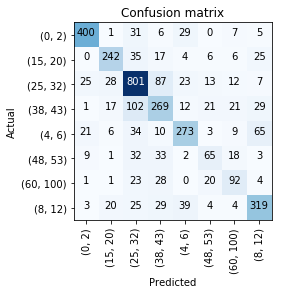

In [17]:
interp.plot_confusion_matrix()

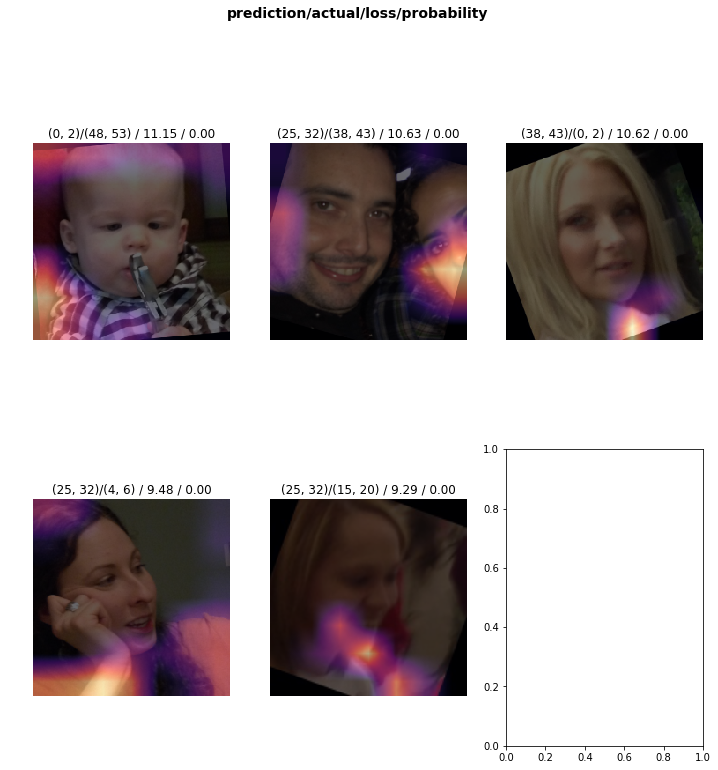

In [22]:
interp.plot_top_losses(5)

In [19]:
help(ClassificationInterpretation)

Help on class ClassificationInterpretation in module fastai.train:

class ClassificationInterpretation(builtins.object)
 |  ClassificationInterpretation(learn: fastai.basic_train.Learner, probs: torch.Tensor, y_true: torch.Tensor, losses: torch.Tensor, ds_type: fastai.basic_data.DatasetType = <DatasetType.Valid: 2>)
 |  
 |  Interpretation methods for classification models.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, learn: fastai.basic_train.Learner, probs: torch.Tensor, y_true: torch.Tensor, losses: torch.Tensor, ds_type: fastai.basic_data.DatasetType = <DatasetType.Valid: 2>)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  confusion_matrix(self, slice_size: int = 1)
 |      Confusion matrix as an `np.ndarray`.
 |  
 |  most_confused(self, min_val: int = 1, slice_size: int = 1) -> Collection[Tuple[str, str, int]]
 |      Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occu

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [12]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [12]:
defaults.device = torch.device('cpu')

In [11]:
path.ls

<bound method <lambda> of PosixPath('data/agedata')>

In [11]:
learn.load('stage-2-resnet50');

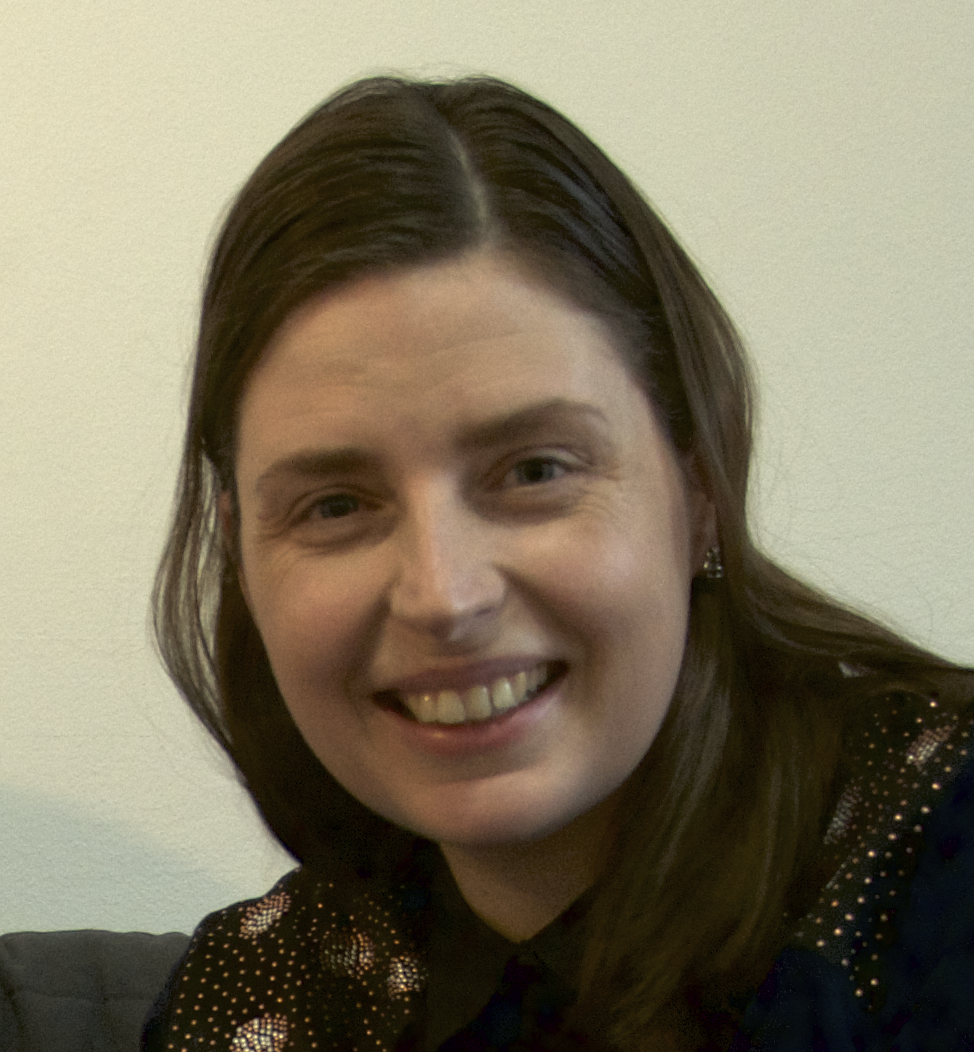

In [28]:
img = open_image(path/'nicoletest2.tiff')
img

We create our `Learner` in production enviromnent like this, jsut make sure that `path` contains the file 'export.pkl' from before.

In [16]:
learn = load_learner(path)

In [29]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category (25, 32)

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [108]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [109]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,28.396381,154796.671875,0.883077,00:08


### Learning rate (LR) too low

In [110]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [119]:
learn.fit_one_cycle(25, max_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.319415,2.166764,0.750769,00:09
1,1.345346,2.163705,0.741538,00:09
2,1.339677,2.177394,0.750769,00:08
3,1.350518,2.177147,0.747692,00:08
4,1.324015,2.185830,0.729231,00:08
5,1.303328,2.226587,0.744615,00:09
6,1.271281,2.236978,0.750769,00:08
7,1.248187,2.286592,0.732308,00:08
8,1.209906,2.306406,0.735385,00:08
9,1.179410,2.380013,0.744615,00:08


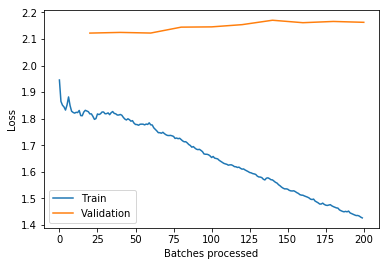

In [118]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2